# SAUCIE 1.3M 10x Demonstration

In [15]:
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import tensorflow as tf
import saucie_utils as utils
import scipy
import saucie

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from saucie_utils import DataSet
from saucie import Saucie
from run import train

np.random.seed(utils.RAND_SEED)
tf.set_random_seed(utils.RAND_SEED)

## Loading and Exploration

In [2]:
GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

In [3]:
filtered_matrix_h5 = "/data/krishnan/mouse_data/1M_neurons_neuron20k.h5"
genome = "mm10"
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)
gene_bc_matrix.matrix.shape # shape of matrix is genes x cells

CPU times: user 1.34 s, sys: 154 ms, total: 1.49 s
Wall time: 1.49 s


(27998, 20000)

In [4]:
centered_x = gene_bc_matrix.matrix.asfptype().transpose()
centered_x = centered_x - centered_x.mean(axis=0)
u, s, vt = scipy.sparse.linalg.svds(centered_x, 20)
pc = u.dot(np.diag(s))

In [5]:
gene_bc_matrix.matrix.min(), gene_bc_matrix.matrix.max(), gene_bc_matrix.matrix.mean()

(0, 7636, 0.17470196085434508)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


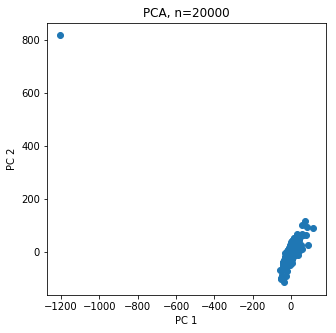

In [6]:
f, ac = plt.subplots(figsize=(5,5))
plt.scatter(pc[:,0], pc[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, n={}'.format(pc.shape[0]))

In [37]:
umis_per_cell = np.asarray(gene_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((gene_bc_matrix.matrix > 0).sum(axis=0)).squeeze()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


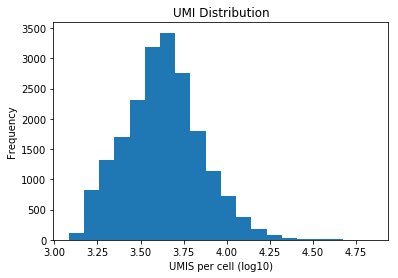

In [38]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


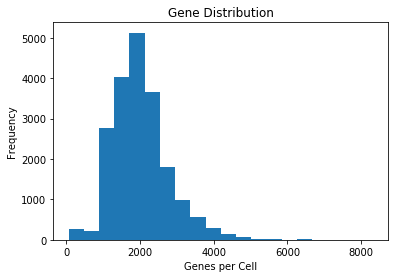

In [39]:
# plot genes per cell
plt.hist(genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

## SAUCIE analysis

In [33]:
config = saucie.default_config()
config['act_fn'] = 'relu'
config['d_act_fn'] = 'relu'
config['input_dim'] = 20
config['sparse_config'] = utils.SparseLayerConfig()
config['save_path'] = './saucie_models/mouse'
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 20)
('encoder_layers', [1024, 512, 256])
('emb_dim', 2)
('act_fn', 'relu')
('d_act_fn', 'relu')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0],l1_lam=[0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0]))
('save_path', './saucie_models/mouse')


In [34]:
ms = MinMaxScaler()
pc_scaled = ms.fit_transform(pc)
train_data, test_data = train_test_split(pc_scaled, train_size=0.9, random_state=utils.RAND_SEED)
data_dict = dict(_data=train_data, _test_data=test_data, labeled=False)
data = DataSet(**data_dict)

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [35]:
# TRAINING FLAGS
batch_size = 200     # size of batch during training
num_epochs = 30      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 50       # training loss logging frequency
save_every = 150     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
debug = False        # enable tfdebug
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

steps_per_epoch = data.num_samples // batch_size
num_steps = steps_per_epoch * num_epochs

In [36]:
sess.close()
tf.reset_default_graph()

In [37]:
if verbose:
    tf.logging.set_verbosity(tf.logging.DEBUG)
else:
    tf.logging.set_verbosity(tf.logging.INFO)
if debug:
    sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    sess.add_tensor_filter('has_inf_or_nan', tf_debug.has_inf_or_nan)

model = Saucie(**config)
plot_dir = model.save_path + '/plots'
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_mem)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
model.build(sess)

In [38]:
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots)

Saving all run data to: ./saucie_models/mouse/17-10-02-runs/2
INFO:tensorflow:Total steps: 2700
INFO:tensorflow:epoch 0, step 40/2700: loss: 0.538188
INFO:tensorflow:epoch 0, step 90/2700: loss: 0.534398
INFO:tensorflow:TESTING -- epoch: 1, loss: 0.535836
INFO:tensorflow:Best model saved after 1 epochs
INFO:tensorflow:epoch 1, step 140/2700: loss: 0.53436
INFO:tensorflow:Saving model, after step 150
INFO:tensorflow:TESTING -- epoch: 2, loss: 0.535599
INFO:tensorflow:Best model saved after 2 epochs
INFO:tensorflow:epoch 2, step 190/2700: loss: 0.533472
INFO:tensorflow:epoch 2, step 240/2700: loss: 0.533114
INFO:tensorflow:TESTING -- epoch: 3, loss: 0.535778
INFO:tensorflow:epoch 3, step 290/2700: loss: 0.533699
INFO:tensorflow:Saving model, after step 300
INFO:tensorflow:epoch 3, step 340/2700: loss: 0.534095
INFO:tensorflow:TESTING -- epoch: 4, loss: 0.535547
INFO:tensorflow:Best model saved after 4 epochs
INFO:tensorflow:epoch 4, step 390/2700: loss: 0.533892
INFO:tensorflow:epoch 4, 

OrderedDict([('loss', 0.53323829)])

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


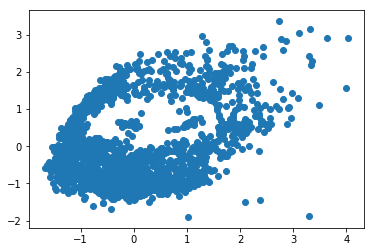

In [39]:
test_emb = sess.run(model.encoder, feed_dict={model.x_: data.test_data, model.is_training_: False})
f, ax = plt.subplots(figsize=)
plt.scatter(test_emb[:,0], test_emb[:,1])
plt.title('Bottleneck embedding with ReLU activation')